# Simple Autoencoders

In [1]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
pandas:  2.2.2
numpy:  1.26.4
seaborn:  0.13.2
matplotlib:  3.9.0
sklearn:  1.5.0
Tensorflow:  2.16.1


In [3]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors = ["orange", "green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
    
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error, 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name==1 else 'o', linestyle='', color='r' if name==1 else 'g', label="Anomaly" if name==1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [4]:
filePath = './creditcard.csv/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis=1), df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


simple autoencoder

In [7]:
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation=None)(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │           377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
autoencoder.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [9]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(x_test, x_test), callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1090 - loss: 1.6579 - mae: 0.7448 - val_accuracy: 0.4096 - val_loss: 0.9112 - val_mae: 0.5767
Epoch 2/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4359 - loss: 0.7367 - mae: 0.5417 - val_accuracy: 0.5150 - val_loss: 0.6097 - val_mae: 0.4932
Epoch 3/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5320 - loss: 0.5053 - mae: 0.4673 - val_accuracy: 0.5912 - val_loss: 0.4949 - val_mae: 0.4338
Epoch 4/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6057 - loss: 0.4234 - mae: 0.4145 - val_accuracy: 0.6355 - val_loss: 0.4354 - val_mae: 0.3971
Epoch 5/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6387 - loss: 0.3735 - mae: 0.3832 - val_accuracy: 0.6532 - val_loss: 0.4070 - val_mae: 0.3786
Epoch 6/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6527 - loss: 0.3649 - mae: 0.3684 - val_accuracy: 0.6640 - val_loss: 0.3914 - val_mae: 0.3659
Epoch 7/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.7143 - loss: 0.3407 - mae: 0.3315 
Test loss: 0.3719082176685333
Test accuracy: 0.33445271849632263


In [11]:
threshold = 10.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [12]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3987
           1       0.29      0.08      0.12        93

    accuracy                           0.97      4080
   macro avg       0.64      0.54      0.55      4080
weighted avg       0.96      0.97      0.97      4080



In [13]:
threshold = 1.0
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


In [14]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3987
           1       0.02      1.00      0.04        93

    accuracy                           0.02      4080
   macro avg       0.01      0.50      0.02      4080
weighted avg       0.00      0.02      0.00      4080



d:\Programming\anomily detection\credit card fraud\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programming\anomily detection\credit card fraud\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programming\anomily detection\credit card fraud\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [15]:
threshold = 5.0
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


In [16]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3987
           1       0.23      0.31      0.26        93

    accuracy                           0.96      4080
   macro avg       0.61      0.64      0.62      4080
weighted avg       0.97      0.96      0.96      4080



In [17]:
roc_auc_score(y_test, y_label)

0.6437494437567254

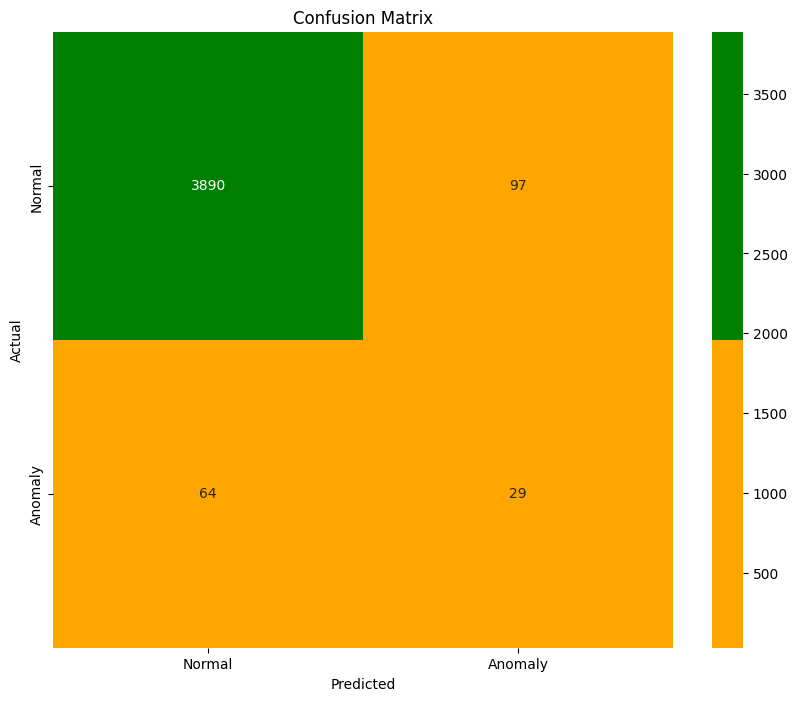

In [18]:
viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

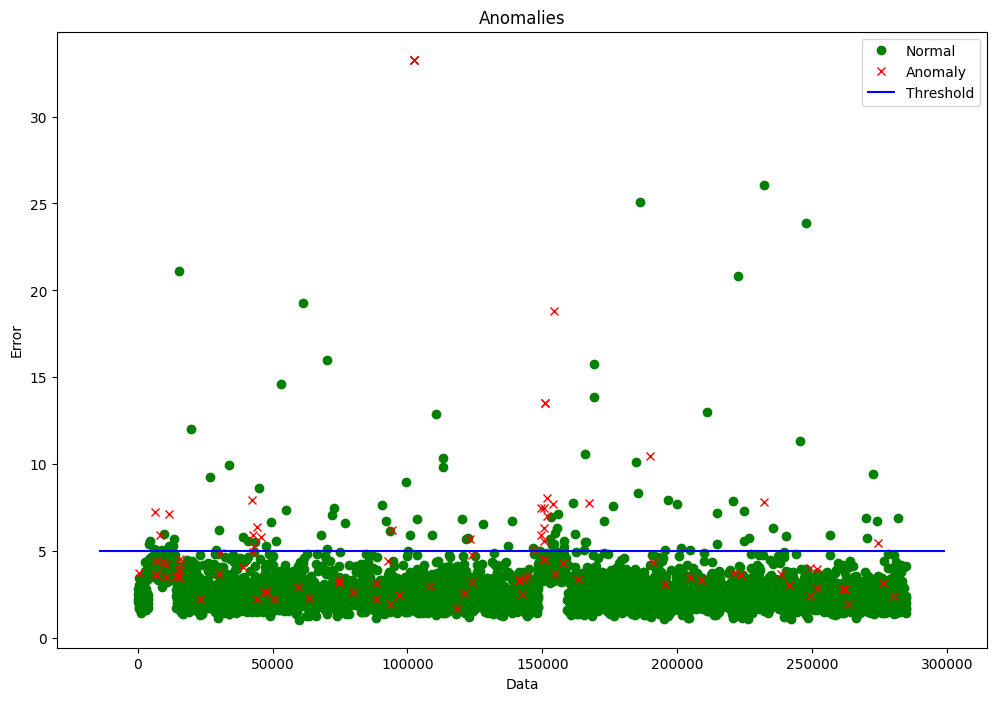

In [19]:
viz.draw_anomaly(y_test, error, threshold)

# Sparse Autoencoders

In [20]:
logfilename = "sparseautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │           377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
autoencoder.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [22]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(x_test, x_test), callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1284 - loss: 1.5789 - mae: 0.6939 - val_accuracy: 0.3027 - val_loss: 1.7384 - val_mae: 0.6999
Epoch 2/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3483 - loss: 1.4482 - mae: 0.6767 - val_accuracy: 0.4056 - val_loss: 1.7048 - val_mae: 0.6841
Epoch 3/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4440 - loss: 1.4054 - mae: 0.6602 - val_accuracy: 0.5137 - val_loss: 1.6874 - val_mae: 0.6769
Epoch 4/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5253 - loss: 1.5688 - mae: 0.6666 - val_accuracy: 0.5373 - val_loss: 1.6804 - val_mae: 0.6754
Epoch 5/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5594 - loss: 1.4569 - mae: 0.6570 - val_accuracy: 0.5735 - val_loss: 1.6756 - val_mae: 0.6747
Epoch 6/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5832 - loss: 1.4331 - mae: 0.6549 - val_accuracy: 0.5902 - val_loss: 1.6726 - val_mae: 0.6743
Epoch 7/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 1.7935 - mae: 0.6795
Test loss: 1.6595371961593628
Test accuracy: 0.6728004217147827


In [24]:
threshold = 10.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3987
           1       0.40      0.77      0.53        93

    accuracy                           0.97      4080
   macro avg       0.70      0.87      0.76      4080
weighted avg       0.98      0.97      0.97      4080



In [26]:
roc_auc_score(y_test, y_label)

0.8738035712840926

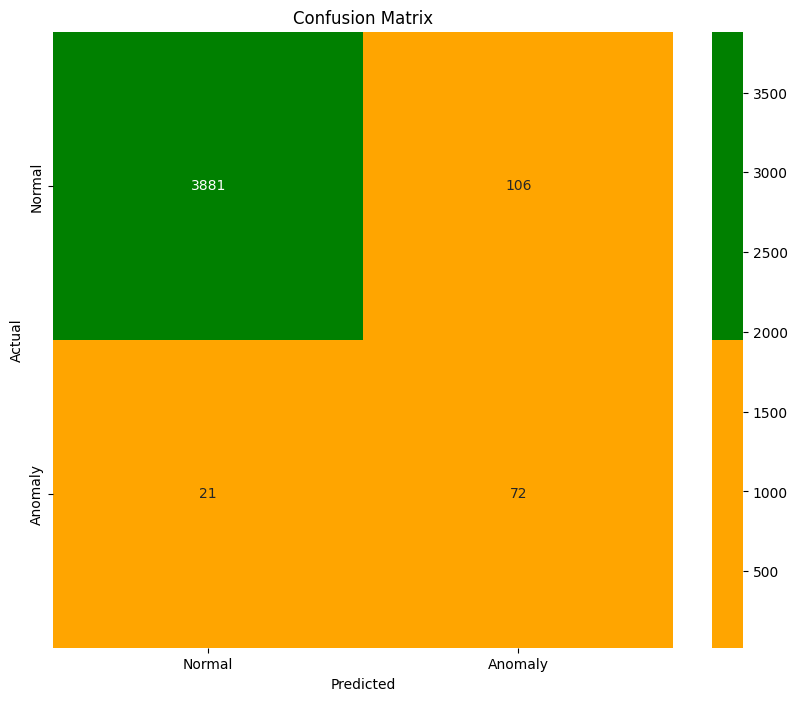

In [27]:
viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

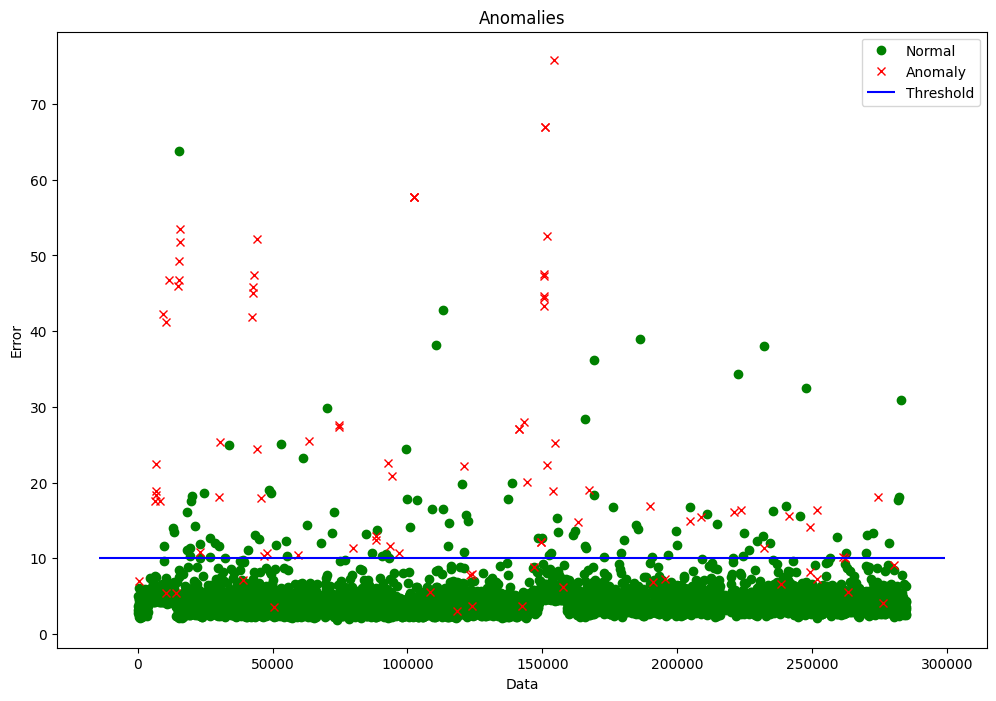

In [28]:
viz.draw_anomaly(y_test, error, threshold)

# Deep Autoencoders

In [29]:
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 29)             │           493 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329 (5.19 KB)

 Trainable params: 1,329 (5.19 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
autoencoder.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [31]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(x_test, x_test), callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0885 - loss: 1.5433 - mae: 0.6886 - val_accuracy: 0.2074 - val_loss: 1.7181 - val_mae: 0.6916
Epoch 2/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2551 - loss: 1.4592 - mae: 0.6696 - val_accuracy: 0.3828 - val_loss: 1.6882 - val_mae: 0.6799
Epoch 3/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4131 - loss: 1.4754 - mae: 0.6639 - val_accuracy: 0.4706 - val_loss: 1.6769 - val_mae: 0.6759
Epoch 4/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4833 - loss: 1.4536 - mae: 0.6597 - val_accuracy: 0.5000 - val_loss: 1.6730 - val_mae: 0.6746
Epoch 5/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5086 - loss: 1.4082 - mae: 0.6541 - val_accuracy: 0.5093 - val_loss: 1.6706 - val_mae: 0.6743
Epoch 6/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5127 - loss: 1.4219 - mae: 0.6567 - val_accuracy: 0.5147 - val_loss: 1.6696 - val_mae: 0.6740
Epoch 7/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 

In [32]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5786 - loss: 1.7928 - mae: 0.6795
Test loss: 1.6592912673950195
Test accuracy: 0.6729909181594849


In [33]:
threshold = 10.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [34]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3987
           1       0.40      0.76      0.52        93

    accuracy                           0.97      4080
   macro avg       0.70      0.87      0.75      4080
weighted avg       0.98      0.97      0.97      4080



In [35]:
roc_auc_score(y_test, y_label)

0.8683018196234537

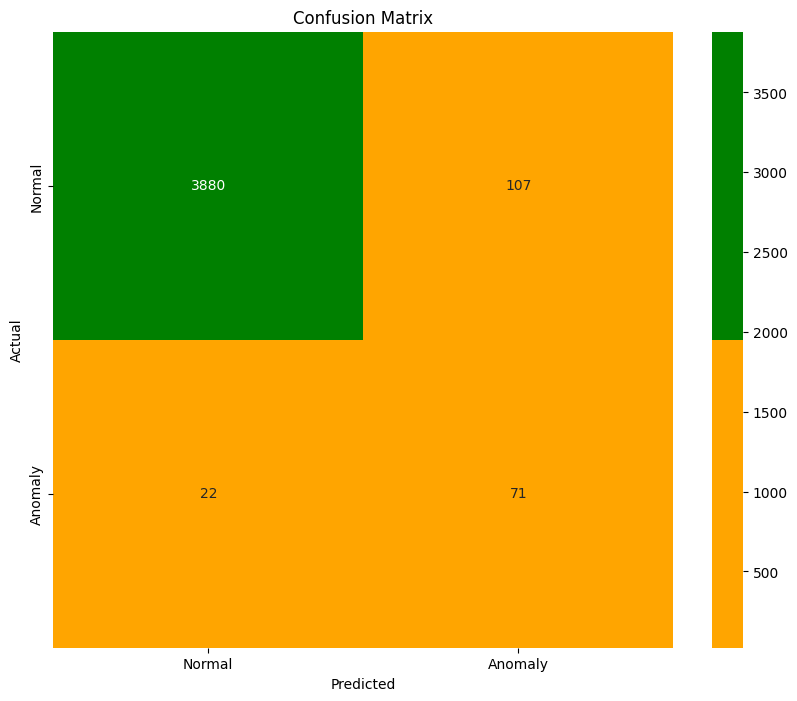

In [36]:
viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

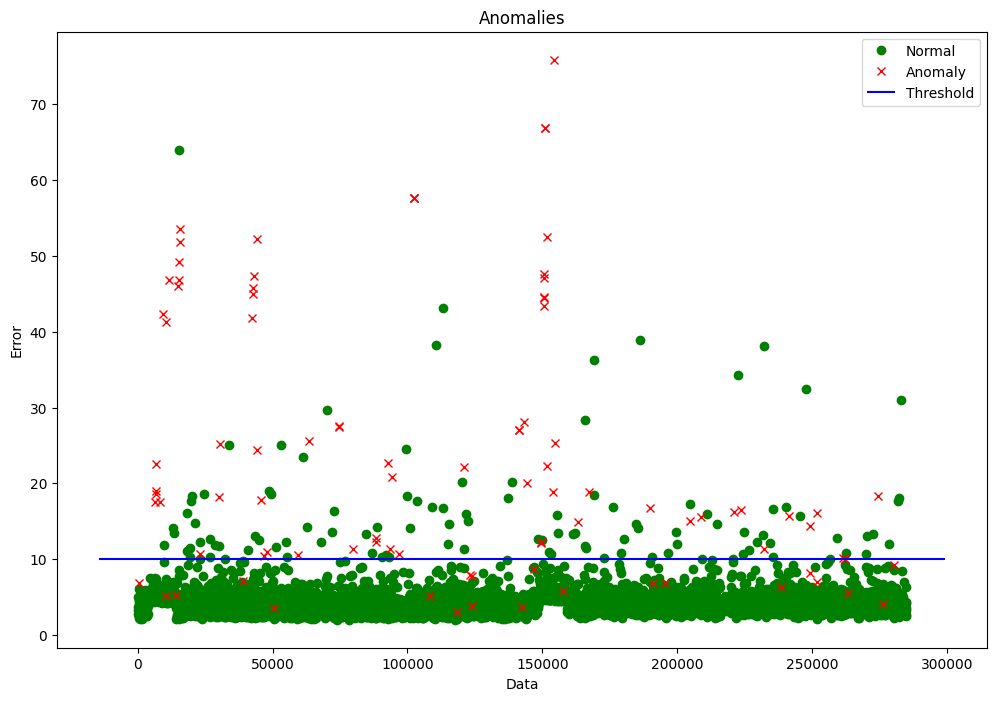

In [37]:
viz.draw_anomaly(y_test, error, threshold)